# Neural Network Exercise 5 (Elman & Jordan Networks)

Amirkabir University of Technology

Dr. Safabakhsh

By Gholamreza Dar 400131018

Spring 2022

## Imports

In [86]:
import os
import datetime

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

## Functions

### Data loading

In [87]:
def convert_label_to_binary(label):
    if label == 'normal' or label == 'ok':
        return 1
    else:
        return 0

In [88]:
def extract_data(file_path):
    '''Parse the data from 'file_path' and store the number lines in the segment list and the label lines in the labels list'''
    segments = []
    labels = []

    with open(file_path, 'r') as f:
        for line in f.readlines():
            # Number line
            if line.startswith("\t"):
                segments.append(list(map(int, line.split())))
            # Whitespace
            elif line.startswith("\n"):
                pass
            # Label line
            else:
                labels.append(convert_label_to_binary(line[:-1]))

    return segments, labels


In [89]:
def load_data():
    '''Load the data from all 5 files and return a (463, 15, 6) numpy array and labels as a (463,) numpy array'''

    base_dir = "data"
    file_names = ["lp1.data", "lp2.data", "lp3.data", "lp4.data", "lp5.data"]
    
    X = []
    y = []

    # Loop through the files and extract the data and concatenate them
    for file_name in file_names:
        segments, labels = extract_data(os.path.join(base_dir, file_name))
        X += segments
        y += labels
    
    # Convert lists to numpy array and reshape them
    X = np.array(X)
    X = X.reshape(-1, 15, 6).astype(np.float32)
    y = np.array(y).astype(np.float32)
    
    return X, y

### Elman network

In [90]:
class ElmanModel(tf.keras.Model):
    def __init__(self, input_dim, hidden_units, feature_size, n_classes):
        super(ElmanModel, self).__init__()
        self.hidden_units = hidden_units
        self.feature_size = feature_size
        self.input_dim = input_dim
        self.n_classes = n_classes

        self.W = self.add_weight(shape=(self.hidden_units, self.feature_size), initializer='random_normal', trainable=True)
        self.U = self.add_weight(shape=(self.hidden_units, self.hidden_units), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(self.hidden_units,), initializer='random_normal', trainable=True)

        self.W_y = self.add_weight(shape=(self.n_classes, self.hidden_units), initializer='random_normal', trainable=True)
        self.b_y = self.add_weight(shape=(self.n_classes,), initializer='random_normal', trainable=True)

    def call(self, x):
        state_t = tf.zeros(self.hidden_units)
        for i in range(self.input_dim):
            state_t = tf.keras.activations.tanh(tf.matmul(self.W, tf.reshape(x[0][i], (self.feature_size, 1))) + tf.matmul(self.U, tf.reshape(state_t, (self.hidden_units,1))) + tf.reshape(self.b, (self.hidden_units, 1)))

        y = tf.keras.activations.sigmoid(tf.matmul(self.W_y, tf.reshape(state_t, (self.hidden_units,1))) + tf.reshape(self.b_y, (self.n_classes,1)))
        return y

    # def evaluate(self, x, y, **kwargs):
    #     y_pred = self(x)
    #     return tf.keras.metrics.binary_accuracy(y, y_pred)

### Jordan Network

In [112]:
class JordanModel(tf.keras.Model):
    def __init__(self, input_dim, hidden_units, feature_size, n_classes):
        super(JordanModel, self).__init__()
        self.hidden_units = hidden_units
        self.feature_size = feature_size
        self.input_dim = input_dim
        self.n_classes = n_classes

        self.W = self.add_weight(shape=(self.hidden_units, self.feature_size), initializer='random_normal', trainable=True)
        self.U = self.add_weight(shape=(self.hidden_units, self.hidden_units), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(self.hidden_units,), initializer='random_normal', trainable=True)

        self.W_y_intermediate = self.add_weight(shape=(self.hidden_units, self.hidden_units), initializer='random_normal', trainable=True)
        self.b_y_intermediate = self.add_weight(shape=(self.hidden_units,), initializer='random_normal', trainable=True)

        self.W_y = self.add_weight(shape=(self.n_classes, self.hidden_units), initializer='random_normal', trainable=True)
        self.b_y = self.add_weight(shape=(self.n_classes,), initializer='random_normal', trainable=True)

    def call(self, x):
        state_t = tf.zeros(self.hidden_units)
        for i in range(self.input_dim):
            hidden = tf.keras.activations.tanh(tf.matmul(self.W, tf.reshape(x[0][i], (self.feature_size, 1))) + tf.matmul(self.U, tf.reshape(state_t, (self.hidden_units,1))) + tf.reshape(self.b, (self.hidden_units, 1)))
            y_intermediate = tf.keras.activations.tanh(tf.matmul(self.W_y_intermediate, tf.reshape(hidden, (self.hidden_units,1))) + tf.reshape(self.b_y_intermediate, (self.hidden_units,1)))
            state_t = y_intermediate
        y = tf.keras.activations.sigmoid(tf.matmul(self.W_y, tf.reshape(state_t, (self.hidden_units,1))) + tf.reshape(self.b_y, (self.n_classes,1)))

        return y
    
    # def evaluate(self, x, y):
    #     y_pred = self(x)
    #     return tf.keras.metrics.binary_accuracy(y, y_pred)

### Experiment functions

In [92]:
def train_elman(hidden_count, epochs=30, n_classes=1, lr=1e-3):
    elman_nn = ElmanModel(input_dim=15, hidden_units=hidden_count, feature_size=6, n_classes=n_classes)

    elman_nn.compile(optimizer=tf.keras.optimizers.Adam(lr),
                    loss='binary_crossentropy',
                    metrics=['acc'])
    elman_nn.fit(
        X_train,
        y_train,
        batch_size=1,
        epochs=epochs,
        validation_data=(X_validation, y_validation),
        callbacks=[tf.keras.callbacks.TensorBoard(log_dir='logs/elman-{}'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))])
    
    test_score = evaluate_model(elman_nn, X_test, y_test)

    return elman_nn, test_score

In [93]:
def train_jordan(hidden_count, epochs=30, n_classes=1, lr=1e-3):
    jordan_nn = JordanModel(input_dim=15, hidden_units=hidden_count, feature_size=6, n_classes=n_classes)

    jordan_nn.compile(optimizer=tf.keras.optimizers.Adam(lr),
                    loss='binary_crossentropy',
                    metrics=['acc'])
    jordan_nn.fit(
        X_train,
        y_train,
        batch_size=1,
        epochs=epochs,
        validation_data=(X_validation, y_validation),
        callbacks=[tf.keras.callbacks.TensorBoard(log_dir='logs/jordan-{}'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))])
    
    test_score = evaluate_model(jordan_nn, X_test, y_test)

    return jordan_nn, test_score

In [94]:
import sklearn.metrics as metrics

def evaluate_model(model, X, y):
    y_preds = []
    for data in X:
        y_pred = model(np.array([data]))
        y_pred = 1 if np.array(y_pred)[0] > 0.5 else 0
        y_preds.append(y_pred)
    
    return metrics.accuracy_score(y, y_preds)

### Ensemble Functions

In [95]:
def create_elman_submodels(hidden_count_list=[10, 25, 50]):
    '''Create a list of Elman submodels'''
    
    submodels = []
    for hidden_count in hidden_count_list:
        # Create a submodel
        elman_submodel = ElmanModel(input_dim=15, hidden_units=hidden_count, feature_size=6, n_classes=2)
        elman_submodel.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['acc'])
        
        # Input layer is needed for the ensemble
        input_layer = tf.keras.Input(shape=(15,6,))
        submodel = tf.keras.Model(inputs=input_layer, outputs=elman_submodel(input_layer))

        submodels.append(submodel)

    return submodels

In [96]:
def create_jordan_submodels(hidden_count_list=[10, 25, 50]):
    '''Create a list of Jordan submodels'''
    
    submodels = []
    for hidden_count in hidden_count_list:
        # Create a submodel
        jordan_submodel = JordanModel(input_dim=15, hidden_units=hidden_count, feature_size=6, n_classes=2)
        jordan_submodel.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['acc'])
        
        # Input layer is needed for the ensemble
        input_layer = tf.keras.Input(shape=(15,6,))
        submodel = tf.keras.Model(inputs=input_layer, outputs=jordan_submodel(input_layer))

        submodels.append(submodel)

    return submodels

In [97]:
def create_ensemble_model(sub_models, active_index=None):
    '''This function takes a list of sub-models and returns an ensemble of them.
    Works with elman and jordan sub-models(and any combination of them).'''

    # We have to rename the layers to avoid duplicate layer names in the ensemble model
    for i, sub_model in enumerate(sub_models):
        for layer in sub_model.layers:
            layer._name = f'ensemble_{i+1}_{layer.name}'

    # Freeze every submodel except for the 'active_index' one(if 'active_index' is set)
    # if active_index is not None:
    #     for i, sub_model in enumerate(sub_models):
    #         if i != active_index:
    #             for layer in sub_model.layers:
    #                 layer.trainable = False
    #         else:
    #             for layer in sub_model.layers:
    #                 layer.trainable = True
        
    # Create the ensemble model
    inputs = [sub_model.input for sub_model in sub_models]
    outputs = [sub_model.output for sub_model in sub_models]
    concat = tf.keras.layers.Concatenate()(outputs)
    ensemble_output = tf.keras.layers.Dense(1, activation='sigmoid')(concat)
    ensemble_output = tf.keras.layers.Flatten()(ensemble_output)
    ensemble_model = tf.keras.Model(inputs=inputs, outputs=ensemble_output)

    # Compile the ensemble model
    ensemble_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['acc'])

    return ensemble_model

In [121]:
def freeze_unfreeze_submodels(active_index, ensemble_model):
    for i in range(len(ensemble_model.layers)):
        # print(i, ensemble_model.layers[i].name)
        if ensemble_model.layers[i].name.startswith(f"ensemble_{active_index}"):
            ensemble_model.layers[i].trainable = True
        elif ensemble_model.layers[i].name.startswith(f"ensemble_"):
            ensemble_model.layers[i].trainable = False

In [122]:
freeze_unfreeze_submodels(0, elman_only_ensemble)

0 ensemble_1_input_5
1 ensemble_2_input_6
2 ensemble_3_input_7
3 ensemble_4_input_8
4 ensemble_1_elman_model_13
5 ensemble_2_elman_model_14
6 ensemble_3_elman_model_15
7 ensemble_4_elman_model_16
8 concatenate_1
9 dense_1
10 flatten_1


In [131]:
import sklearn.metrics as metrics
def evaluate_ensemble(model, X, y):
    '''Evaluates the ensemble model on the test set.'''
    
    y_preds = []
    for data in X:
        replicate_data = [tf.convert_to_tensor(np.array([data])) for _ in range(len(model.input))]
        y_pred = model(replicate_data)[0][0]
        y_pred = 1 if np.array(y_pred) > 0.5 else 0
        y_preds.append(y_pred)
    
    return metrics.accuracy_score(y, y_preds)

### Ensemble Experiment Functions


In [99]:
def elman_only_ensemble_experiment(hidden_count_list=[10, 25, 50]):
    '''Creates elman sub-models, makes an ensemble out of them,
    trains the ensemble, reports test accuracy and returns the model.'''

    # Create the sub-models
    elman_submodels = create_elman_submodels(hidden_count_list)

    # Create the ensemble model
    ensemble_model = create_ensemble_model(elman_submodels)

    # Copy X_train and X_validation for all of the sub-models
    X_train_ensemble = [X_train for i in range(len(elman_submodels))]
    X_validation_ensemble = [X_validation for i in range(len(elman_submodels))]
    X_test_ensemble = [X_test for i in range(len(elman_submodels))]
    
    # Train the ensemble model
    ensemble_model.fit(
        X_train_ensemble,
        y_train,
        batch_size=1,
        epochs=30,
        validation_data=(X_validation_ensemble, y_validation),
        callbacks=[tf.keras.callbacks.TensorBoard(log_dir='logs/elman_only_ensemble-{}'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))])

    # Report test accuracy
    test_accuracy = evaluate_ensemble(ensemble_model, X_test, y_test)
    

    return ensemble_model, test_accuracy

In [100]:
def jordan_only_ensemble_experiment(hidden_count_list=[10, 25, 50]):
    '''Creates jordan sub-models, makes an ensemble out of them,
    trains the ensemble, reports test accuracy and returns the model.'''

    # Create the sub-models
    jordan_submodels = create_jordan_submodels(hidden_count_list)

    # Create the ensemble model
    ensemble_model = create_ensemble_model(jordan_submodels)

    # Copy X_train and X_validation for all of the sub-models
    X_train_ensemble = [X_train for i in range(len(jordan_submodels))]
    X_validation_ensemble = [X_validation for i in range(len(jordan_submodels))]
    X_test_ensemble = [X_test for i in range(len(jordan_submodels))]
    
    # Train the ensemble model
    ensemble_model.fit(
        X_train_ensemble,
        y_train,
        batch_size=1,
        epochs=30,
        validation_data=(X_validation_ensemble, y_validation),
        callbacks=[tf.keras.callbacks.TensorBoard(log_dir='logs/jordan_only_ensemble-{}'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))])

    # Report test accuracy
    test_accuracy = evaluate_ensemble(ensemble_model, X_test, y_test)

    return ensemble_model, test_accuracy

In [101]:
# X_train_list = []
# X_train_fixed = X_train[:-(X_train.shape[0]%6)]
# for i in range(6):
#     X_train_current = X_train_fixed[int(i*X_train_fixed.shape[0]/6):int((i+1)*X_train_fixed.shape[0]/6)]
#     X_train_list.append(X_train_current)

# len(X_train_list[3])

In [102]:
def endgame_ensemble_experiment(elman_hidden_count_list=[10, 25, 50], jordan_hidden_count_list=[10, 25, 50]):
    '''Creates elman and jordan sub-models, makes an ensemble out of them,
    trains the ensemble, reports test accuracy and returns the model.'''

    # Create the sub-models
    elman_submodels = []
    if len(elman_hidden_count_list)>0:
        elman_submodels = create_elman_submodels(elman_hidden_count_list)

    jordan_submodels = []
    if len(jordan_hidden_count_list)>0:
        jordan_submodels = create_jordan_submodels(jordan_hidden_count_list)

    # Total count of sub-models
    total_submodels = len(elman_submodels) + len(jordan_submodels)

    # Split X_train for each sub-model
    X_train_list = []
    X_train_fixed = X_train[:-(X_train.shape[0]%6)]
    for i in range(6):
        X_train_current = X_train_fixed[int(i*X_train_fixed.shape[0]/6):int((i+1)*X_train_fixed.shape[0]/6)]
        X_train_list.append(X_train_current)

    # Choose X_train and copy X_validation for all of the sub-models
    X_train_ensemble = [X_train_list[i] for i in range(total_submodels)]
    X_validation_ensemble = [X_validation for i in range(total_submodels)]
    X_test_ensemble = [X_test for i in range(total_submodels)]
    
    ensemble_model = create_ensemble_model(elman_submodels + jordan_submodels)

    # Train the ensemble model
    ensemble_model.fit(
        X_train_ensemble,
        y_train,
        batch_size=1,
        epochs=30,
        validation_data=(X_validation_ensemble, y_validation),
        callbacks=[tf.keras.callbacks.TensorBoard(log_dir='logs/endgame_ensemble-{}'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))])

    # Report test accuracy
    test_accuracy = evaluate_ensemble(ensemble_model, X_test, y_test)

    return ensemble_model, test_accuracy

## Main

### Loading the data

In [103]:
X, y = load_data()
print("X.shape:", X.shape)
print("X.dtype:", X.dtype)
print("y.shape:", y.shape)
print("y.dtype:", y.dtype)

X.shape: (463, 15, 6)
X.dtype: float32
y.shape: (463,)
y.dtype: float32


### Train, Test, validation split

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.125, random_state=1)

### Normalize Dataset?

In [105]:
# Normalize the data

### Experiments

#### Elman

In [106]:
# elman_nn = ElmanModel(input_dim=15, hidden_units=10, feature_size=6, n_classes=1)

# elman_nn.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
#                 loss='binary_crossentropy',
#                 metrics=['acc'])
# elman_nn.fit(
#     X_train,
#     y_train,
#     batch_size=1,
#     epochs=30,
#     validation_data=(X_validation, y_validation),
#     callbacks=[tf.keras.callbacks.TensorBoard(log_dir='logs/elman-{}'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))])

In [107]:
# tf.keras.utils.plot_model(elman_nn, show_shapes=True)

In [108]:
# i = 27
# print(elman_nn(X_test[np.newaxis,i]))
# print(y_test[i])

In [109]:
# evaluate_model(elman_nn,X_test, y_test)

In [110]:
# Experiment with different hidden layer counts
elman_10, elman_10_score = train_elman(10)
elman_25, elman_25_score = train_elman(25)
elman_50, elman_50_score = train_elman(50)
elman_75, elman_75_score = train_elman(75)
elman_100, elman_100_score = train_elman(100)
elman_200, elman_200_score = train_elman(200)

Epoch 1/30
323/323 [==============================] - 2s 4ms/step - loss: 0.6522 - acc: 0.6780 - val_loss: 0.5930 - val_acc: 0.7021
Epoch 2/30
323/323 [==============================] - 1s 2ms/step - loss: 0.5418 - acc: 0.7678 - val_loss: 0.4810 - val_acc: 0.7660
Epoch 3/30
323/323 [==============================] - 1s 2ms/step - loss: 0.4727 - acc: 0.7895 - val_loss: 0.4457 - val_acc: 0.7660
Epoch 4/30
323/323 [==============================] - 1s 2ms/step - loss: 0.4284 - acc: 0.7988 - val_loss: 0.4069 - val_acc: 0.7447
Epoch 5/30
323/323 [==============================] - 1s 3ms/step - loss: 0.3998 - acc: 0.7926 - val_loss: 0.3853 - val_acc: 0.8085
Epoch 6/30
323/323 [==============================] - 1s 2ms/step - loss: 0.3910 - acc: 0.7988 - val_loss: 0.3621 - val_acc: 0.8298
Epoch 7/30
323/323 [==============================] - 1s 2ms/step - loss: 0.3612 - acc: 0.8452 - val_loss: 0.3519 - val_acc: 0.8085
Epoch 8/30
323/323 [==============================] - 1s 2ms/step - loss: 0.

In [111]:
print("elman_10_score:", elman_10_score)
print("elman_25_score:", elman_25_score)
print("elman_50_score:", elman_50_score)
print("elman_75_score:", elman_75_score)
print("elman_100_score:", elman_100_score)
print("elman_200_score:", elman_200_score)

elman_10_score: 0.8817204301075269
elman_25_score: 0.9139784946236559
elman_50_score: 0.9354838709677419
elman_100_score: 0.967741935483871


#### Jordan

In [ ]:
# jordan_nn = JordanModel(input_dim=15, hidden_units=10, feature_size=6, n_classes=2)

# jordan_nn.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
#                 loss='binary_crossentropy',
#                 metrics=['acc'])

# jordan_nn.fit(
#     X_train,
#     y_train,
#     batch_size=1,
#     epochs=30,
#     validation_data=(X_validation, y_validation),
#     callbacks=[tf.keras.callbacks.TensorBoard(log_dir='logs/jordan-{}'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))])

In [ ]:
# evaluate_model(jordan_nn,X_test, y_test)

In [113]:
jordan_10, jordan_10_score = train_jordan(10)
jordan_25, jordan_25_score = train_jordan(25)
jordan_50, jordan_50_score = train_jordan(50)
jordan_75, jordan_75_score = train_jordan(75)
jordan_100, jordan_100_score = train_jordan(100)

Epoch 1/30
323/323 [==============================] - 4s 5ms/step - loss: 0.6309 - acc: 0.6656 - val_loss: 0.5346 - val_acc: 0.7021
Epoch 2/30
323/323 [==============================] - 1s 3ms/step - loss: 0.4510 - acc: 0.7864 - val_loss: 0.3589 - val_acc: 0.8085
Epoch 3/30
323/323 [==============================] - 1s 3ms/step - loss: 0.3930 - acc: 0.8173 - val_loss: 0.3426 - val_acc: 0.8511
Epoch 4/30
323/323 [==============================] - 1s 3ms/step - loss: 0.3478 - acc: 0.8235 - val_loss: 0.2802 - val_acc: 0.8511
Epoch 5/30
323/323 [==============================] - 1s 3ms/step - loss: 0.3257 - acc: 0.8204 - val_loss: 0.2657 - val_acc: 0.8936
Epoch 6/30
323/323 [==============================] - 1s 2ms/step - loss: 0.2913 - acc: 0.8359 - val_loss: 0.2543 - val_acc: 0.8723
Epoch 7/30
323/323 [==============================] - 1s 2ms/step - loss: 0.2846 - acc: 0.8545 - val_loss: 0.2757 - val_acc: 0.8723
Epoch 8/30
323/323 [==============================] - 1s 2ms/step - loss: 0.

In [114]:
print("jordan_10_score:", jordan_10_score)
print("jordan_25_score:", jordan_25_score)
print("jordan_50_score:", jordan_50_score)
print("jordan_75_score:", jordan_75_score)
print("jordan_100_score:", jordan_100_score)

jordan_10_score: 0.8709677419354839
jordan_25_score: 0.9247311827956989
jordan_50_score: 0.8494623655913979
jordan_100_score: 0.9139784946236559


### Ensemble

#### Elman Only 

In [ ]:
elman_only_ensemble, elman_only_ensemble_score = elman_only_ensemble_experiment(
    hidden_count_list=[10, 25, 50, 100])

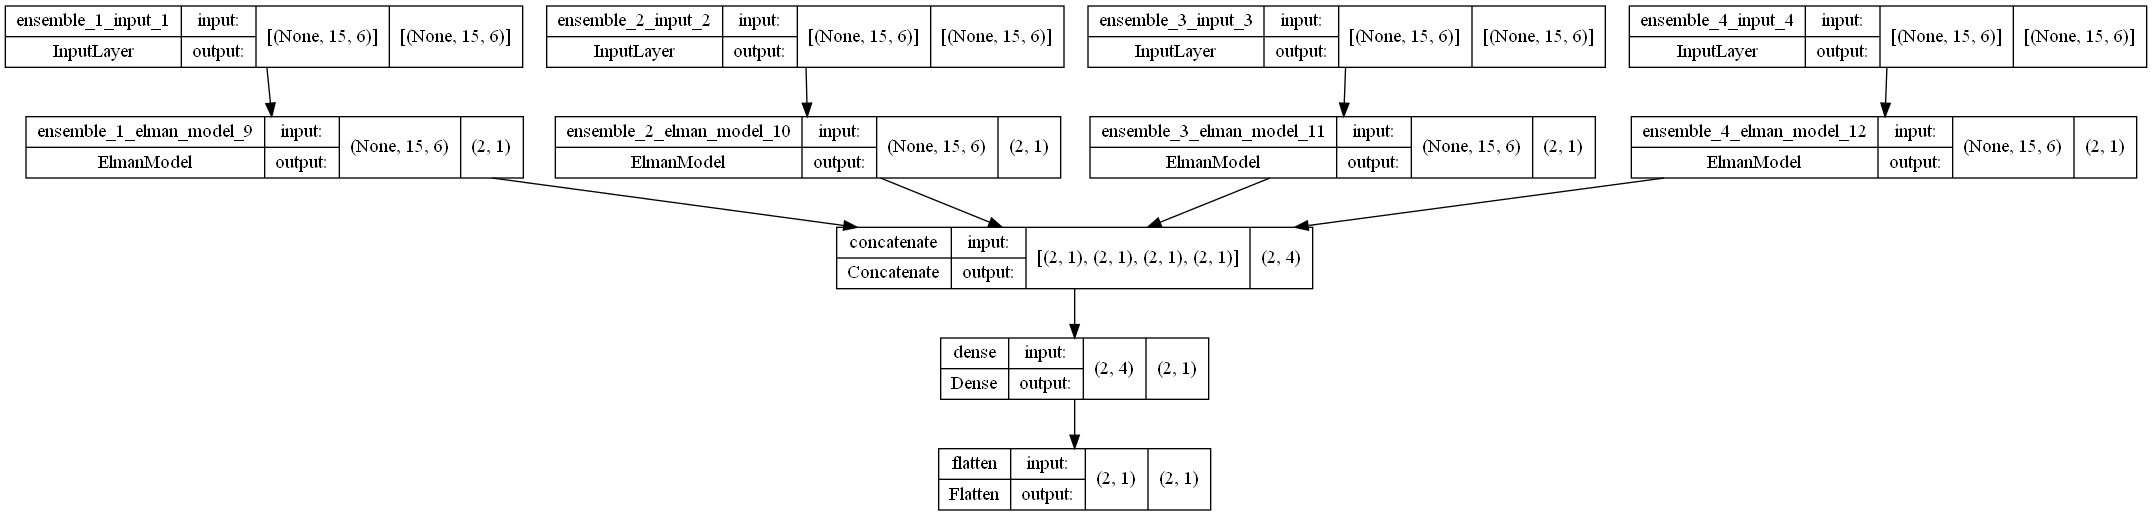

In [116]:
tf.keras.utils.plot_model(elman_only_ensemble, to_file='elman_only_ensemble.png', show_shapes=True)

In [128]:
# elman_only_ensemble, elman_only_ensemble_score = elman_only_ensemble_experiment(
#     hidden_count_list=[100, 100, 100, 100])

#### Jordan Only

In [119]:
jordan_only_ensemble, jordan_only_ensemble_score = jordan_only_ensemble_experiment(
    hidden_count_list=[10, 25, 50])

Epoch 1/30
323/323 [==============================] - 9s 10ms/step - loss: 0.5682 - acc: 0.7229 - val_loss: 0.4777 - val_acc: 0.7660
Epoch 2/30
323/323 [==============================] - 1s 4ms/step - loss: 0.4609 - acc: 0.7632 - val_loss: 0.4026 - val_acc: 0.8830
Epoch 3/30
323/323 [==============================] - 1s 3ms/step - loss: 0.4279 - acc: 0.7833 - val_loss: 0.3946 - val_acc: 0.8085
Epoch 4/30
323/323 [==============================] - 1s 4ms/step - loss: 0.3929 - acc: 0.8235 - val_loss: 0.3847 - val_acc: 0.8085
Epoch 5/30
323/323 [==============================] - 1s 3ms/step - loss: 0.3717 - acc: 0.8142 - val_loss: 0.3774 - val_acc: 0.8085
Epoch 6/30
323/323 [==============================] - 1s 3ms/step - loss: 0.3643 - acc: 0.8142 - val_loss: 0.3466 - val_acc: 0.8298
Epoch 7/30
323/323 [==============================] - 1s 3ms/step - loss: 0.3466 - acc: 0.8467 - val_loss: 0.3421 - val_acc: 0.8298
Epoch 8/30
323/323 [==============================] - 1s 3ms/step - loss: 0

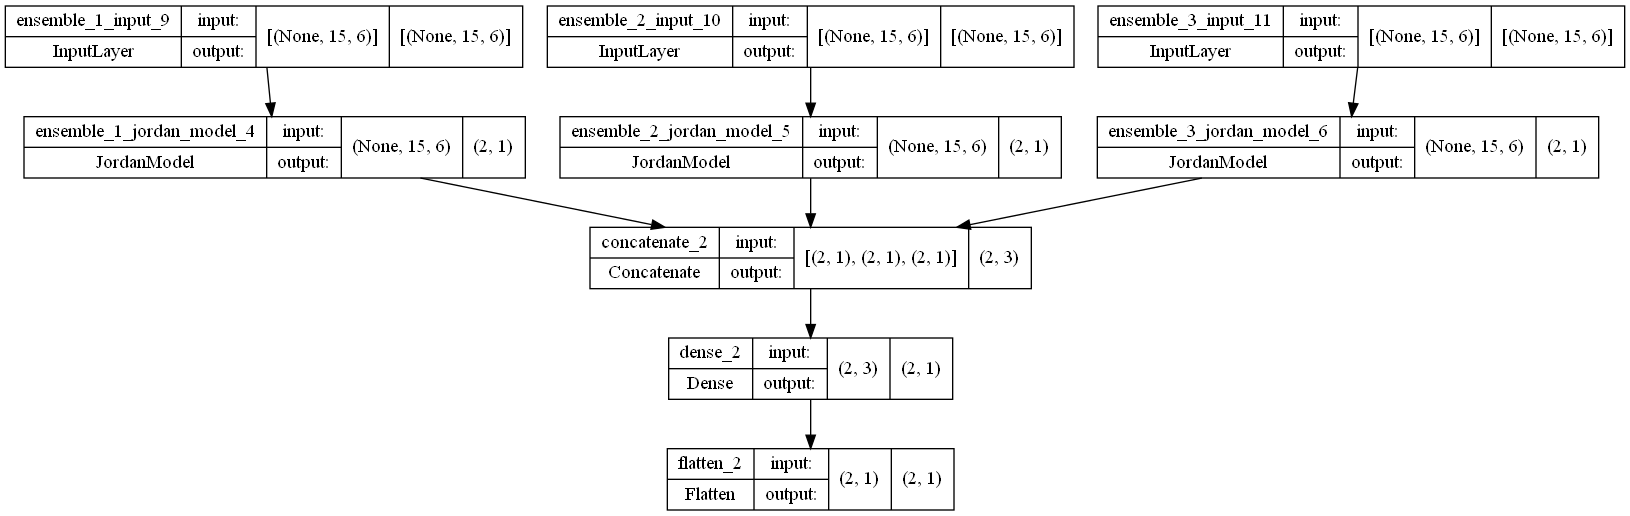

In [120]:
tf.keras.utils.plot_model(jordan_only_ensemble, to_file='jordan_only_ensemble.png', show_shapes=True)

#### Mixed

In [ ]:
mixed_ensemble, mixed_ensemble_score = endgame_ensemble_experiment(
    elman_hidden_count_list=[10, 25, 50],
    jordan_hidden_count_list=[10, 25, 50])

## Tensorboard

In [ ]:
# load tensorboard extension
%load_ext tensorboard

# start tensorboard in the 'logs' directory
%tensorboard --logdir=logs/